<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import time
from collections import Counter

In [6]:

def load_data(url):
    try:
        df = pd.read_csv(url)
        print("Данные успешно загружены из URL.")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        from google.colab import files
        uploaded = files.upload()
        df = pd.read_csv(next(iter(uploaded)))
        print("Данные успешно загружены из локального файла.")
    return df

url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = load_data(url)


Данные успешно загружены из URL.


In [ ]:
#Проверяем структуру данных: количество строк, столбцов, типы данных.

                                              #Считаем пропущенные значения по столбцам.

                                                                              #Проверяем и удаляем дубликаты, чтобы избежать искажения анализа.

print("\nИнформация о данных:")
print(df.info())

print("\nСтатистика по пропущенным значениям:")
print(df.isnull().sum())

print("\nКоличество дубликатов:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


In [8]:
#Выбираем только нужные числовые признаки для анализа.

                                                       #Удаляем строки с пропущенными значениями, чтобы модели обучались на чистых данных.


feature_columns = [
    'debts', 'bequests', 'wife', 'husband',
    'sons', 'daughters', 'father', 'mother', 'brothers', 'sisters'
]

df_clean = df[feature_columns].dropna()
print(f"\nРазмер данных после удаления пропусков: {df_clean.shape}")



Размер данных после удаления пропусков: (10000, 10)


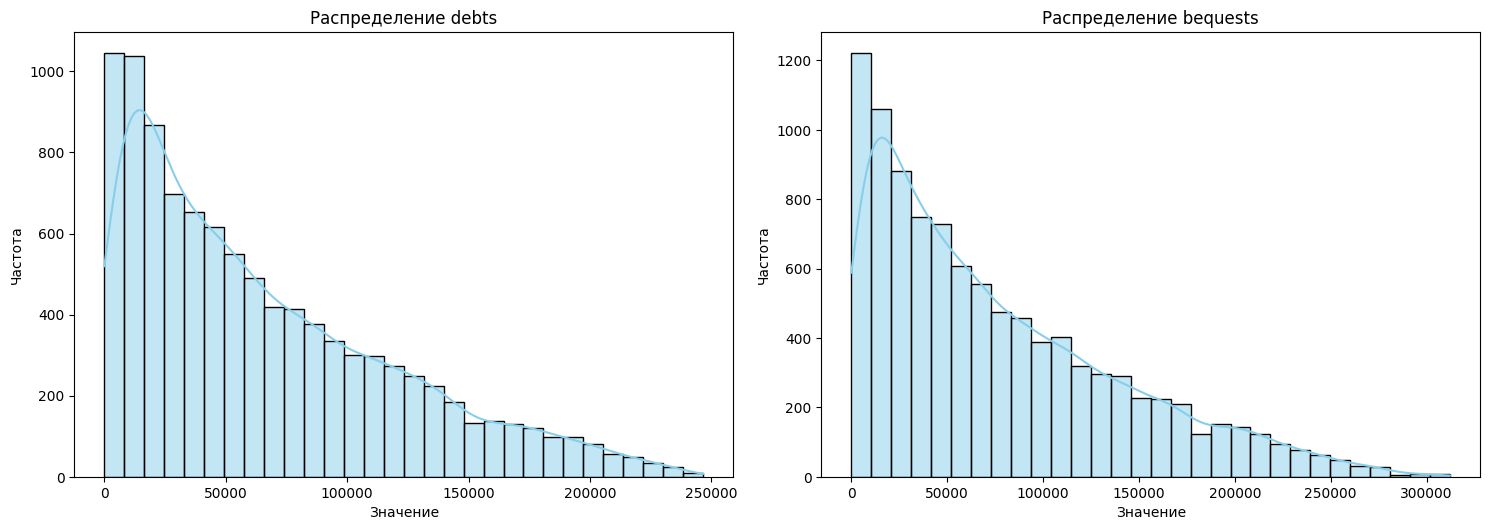

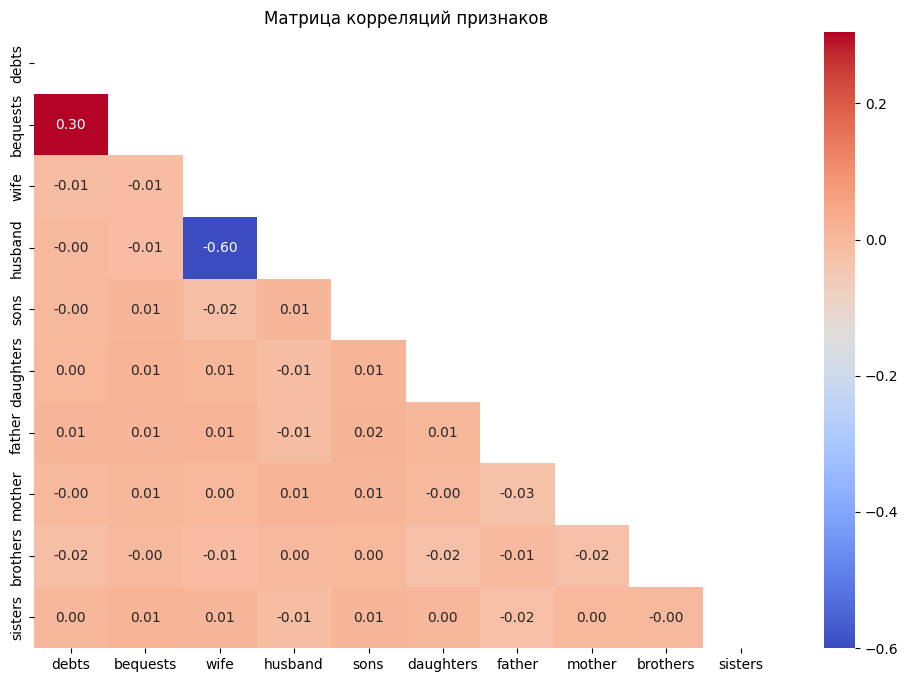

In [9]:
#Строим гистограммы для ключевых финансовых признаков, чтобы увидеть распределение данных.

                                                                 #Строим тепловую карту корреляций, чтобы понять взаимосвязи между признаками.


plot_histograms(df_clean, ['debts', 'bequests'])
plot_correlation_heatmap(df_clean)


In [ ]:
#Создаём бинарный целевой признак high_bequest:

#1 - если завещание выше медианы,

#0 - если ниже.

#Визуализируем распределение классов, чтобы проверить баланс.

median_bequest = df_clean['bequests'].median()
df_clean['high_bequest'] = (df_clean['bequests'] >= median_bequest).astype(int)
plot_class_distribution(df_clean, 'high_bequest')


In [11]:

#Проверяем баланс классов - важно для корректного обучения.

                                        #Разделяем данные на признаки X и целевой признак y.

                                                             #Разбиваем данные на обучающую и тестовую выборки с сохранением пропорций классов.
class_counts = df_clean['high_bequest'].value_counts()
print(f"\nБаланс классов:\n{class_counts}")

X = df_clean.drop(columns=['high_bequest', 'bequests'])
y = df_clean['high_bequest']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Баланс классов:
high_bequest
0    5000
1    5000
Name: count, dtype: int64


In [12]:
#Стандартизируем признаки, чтобы привести их к единому масштабу (среднее 0, стандартное отклонение 1).

                                                    #Это улучшает работу многих моделей, особенно KNN.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
#Проверяем баланс классов в обучающей выборке.

#Если дисбаланс значительный (меньший класс менее 50% от большего), применяем SMOTE - метод синтетического увеличения меньшего класса.



print(f"\nДо SMOTE: {Counter(y_train)}")
if min(class_counts) / max(class_counts) < 0.5:
    smote = SMOTE(random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
    print(f"После SMOTE: {Counter(y_train)}")



До SMOTE: Counter({0: 4000, 1: 4000})


In [ ]:
#Обучаем две модели: KNN и Random Forest.

                           #Оцениваем качество с помощью кросс-валидации по метрике F1-score.

                                                         #Обучаем модели на всей обучающей выборке.

                                                                       #Оцениваем модели на тестовой выборке, выводим отчёты и визуализации.


models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

for name, model in models.items():
    start_time = time.time()
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"\n{name} кросс-валидация F1-score: {scores.mean():.4f} ± {scores.std():.4f}")

    model.fit(X_train_scaled, y_train)
    end_time = time.time()
    print(f"{name} обучена за {end_time - start_time:.2f} секунд")

    evaluate_model(model, X_test_scaled, y_test, name)


In [ ]:
#Подбираем лучшие параметры для KNN с помощью GridSearchCV.

                                                  #Обучаем оптимизированную модель и оцениваем её качество.


param_grid = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
print(f'\nЛучшие параметры KNN: {grid_search.best_params_}')
evaluate_model(best_knn, X_test_scaled, y_test, "KNN (optimized)")


In [ ]:
#Обучаем Random Forest для оценки важности признаков.

                                                          #Визуализируем, какие признаки больше всего влияют на предсказания.



forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
forest.fit(X_train_scaled, y_train)

feat_importances = pd.Series(forest.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10,6))
feat_importances.plot(kind='barh', color='teal')
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Важность')
plt.show()


In [ ]:
#PCA - линейное уменьшение размерности для визуализации в 3D.
#t-SNE - нелинейное уменьшение размерности для визуализации в 2D,
#хорошо показывает структуру классов.
plot_pca_3d(X_train_scaled, y_train)
plot_tsne_2d(X_train_scaled, y_train)
